## Introduction to the dataset

- World Health Organization has  estimated 12 million deaths occur worldwide, every year due to Heart diseases.

- Half the deaths in the United States and other developed countries are due to cardio vascular diseases. 

- The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications.

- This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.


In [70]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer
sc = StandardScaler()
le = LabelEncoder()

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
rfr = RandomForestRegressor()
rfc = RandomForestClassifier()
import warnings
warnings.filterwarnings('ignore')

In [50]:
def split_data(df, y = target_var):
    x = df.loc[:, df.columns != y]
    y = df.loc[:, y]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)
    # x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size = 0.2, random_state = 123)

    return x_train, x_test, y_train, y_test

In [51]:
def get_acc(model, x, y, type_of_y):
    pred_acc = model.predict(x)
    if type_of_y in ['float', 'int']:
        return math.sqrt(mean_squared_error(pred_acc, y))
    elif type_of_y == 'category':
        return accuracy_score(y, pred_acc)
    else:
        print("No Accuracy")

In [27]:
# Test
dfp = pd.read_csv('US_Heart_Patients.csv')
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [28]:
target_var = 'TenYearCHD'

In [29]:
dfp.shape

(4240, 16)

###  EDA and Feature Engineering

#### Univariate Analysis

In [30]:
# Caonverting object and numerical to category

to_be_cat = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
dfp[to_be_cat]= dfp[to_be_cat].astype('category')
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             4240 non-null   category
 1   age              4240 non-null   int64   
 2   education        4135 non-null   category
 3   currentSmoker    4240 non-null   category
 4   cigsPerDay       4211 non-null   float64 
 5   BPMeds           4187 non-null   category
 6   prevalentStroke  4240 non-null   category
 7   prevalentHyp     4240 non-null   category
 8   diabetes         4240 non-null   category
 9   totChol          4190 non-null   float64 
 10  sysBP            4240 non-null   float64 
 11  diaBP            4240 non-null   float64 
 12  BMI              4221 non-null   float64 
 13  heartRate        4239 non-null   float64 
 14  glucose          3852 non-null   float64 
 15  TenYearCHD       4240 non-null   category
dtypes: category(8), float64(7), int64(1)
memor

In [31]:
not_to_plot = []

In [32]:
rand_color = ['red', 'blue', 'green']

In [33]:
dfp.TenYearCHD.replace(to_replace={1: 'Yes', 0:'No'}, inplace=True)
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,Yes
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No


In [34]:
def univariate(df, rows = 4, cols = 4):
    fig=plt.figure(figsize=(20,20))
    for j, i in enumerate(df.columns):
        ax=fig.add_subplot(rows,cols,j+1)
        if i in df.select_dtypes(['category']):
            sns.countplot(x= i, data = df, ax=ax)
        if i in df.select_dtypes(['int', 'float64']):
            sns.distplot(x = df[i], ax=ax, color=np.random.choice(rand_color))
    fig.tight_layout() 
    plt.show()

In [35]:
# univariate(dfp)

#### Bivariate Analysis

In [36]:
def bivariate(df, y = target_var, cols = 4, rows = 4):
    temp = not_to_plot[:]
    temp.append(y)
    fig=plt.figure(figsize=(25,20))

    for j, i in enumerate(df.columns):
        if df[y].dtype == 'float':
            if i in df.select_dtypes(['category']):
                if (i not in temp): 
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = i, y = y, data = df)

            if i in df.select_dtypes(['float', 'int']):                
                if (i not in temp):      
                    ax=fig.add_subplot(rows,cols,j+1)       
                    sns.scatterplot(x = y, y = i, data = df)                  
            
        elif df[y].dtype == 'category':
            if i in df.select_dtypes(['category']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.countplot(x = i, hue = y, data = df)
                    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

            if i in df.select_dtypes(['float', 'int']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = y, y = i, data = df)
    fig.tight_layout() 
    plt.show()

In [37]:
# bivariate(dfp)

#### Missing Values

In [38]:
dfp.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [39]:
# % of all missing var
miss_df = pd.DataFrame(dfp.isnull().sum(), columns=['Miss_Values'])
for i in miss_df.index:
    val = miss_df._get_value(i, miss_df.columns[0]) 
    if val > 0:
        print(i, "% : ", val*100/dfp.shape[0])

education % :  2.4764150943396226
cigsPerDay % :  0.6839622641509434
BPMeds % :  1.25
totChol % :  1.179245283018868
BMI % :  0.4481132075471698
heartRate % :  0.02358490566037736
glucose % :  9.150943396226415


In [40]:
# Case 1: Drop All Null Values.
dfp.dropna(inplace=True)
dfp.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [41]:
dfp.TenYearCHD = le.fit_transform(dfp.TenYearCHD)
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


#### Treating Imbalanced Dataset

Trying Oversampling using SMOTE

In [42]:
dfp.loc[:, dfp.columns!='TenYearCHD'].head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0


In [43]:
# oversample = SMOTE()
# x = dfp.loc[:, dfp.columns != 'TenYearCHD']
# y = dfp.loc[:, dfp.columns == 'TenYearCHD']
# x, y = oversample.fit_resample(x, y)
# dfp = pd.concat([x, y], axis=1)

In [44]:
nr = NearMiss() 
x = dfp.loc[:, dfp.columns != 'TenYearCHD']
y = dfp.loc[:, dfp.columns == 'TenYearCHD']
X_near, Y_near= nr.fit_resample(x, y)
dfp = pd.concat([X_near, Y_near], axis=1)

In [45]:
dfp.TenYearCHD.value_counts()

0    557
1    557
Name: TenYearCHD, dtype: int64

#### Model Building

##### 1. Logistic Regression

In [46]:
# Adding Constant variable
from statsmodels.tools import add_constant as ac
dfp_constant = ac(dfp)
dfp_constant.head()

,const,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,0,44,1.0,0,0.0,0.0,0,0,0,212.0,132.0,82.0,28.72,75.0,73.0,0
1,1.0,1,56,2.0,0,0.0,0.0,0,1,0,241.0,130.0,85.0,25.79,68.0,78.0,0
2,1.0,1,54,1.0,0,0.0,0.0,0,0,0,235.0,132.0,87.0,26.13,65.0,75.0,0
3,1.0,0,57,2.0,0,0.0,0.0,0,0,0,274.0,116.0,83.0,25.77,70.0,83.0,0
4,1.0,1,48,1.0,0,0.0,0.0,0,0,0,231.0,121.0,81.0,27.56,70.0,85.0,0


In [47]:
dfp.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [48]:
col = dfp_constant.columns[:-1]
model = sm.Logit(dfp.TenYearCHD,dfp_constant[col])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.532948
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 1114
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                           15
Date:                Tue, 05 Jul 2022   Pseudo R-squ.:                  0.2311
Time:                        10:54:03   Log-Likelihood:                -593.70
converged:                       True   LL-Null:                       -772.17
Covariance Type:            nonrobust   LLR p-value:                 7.478e-67
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -11.2321      1.338     -8.392      0.000     -13.855      -8.609
male                0.5336      0.152      3.510      0.000       0.236       0.831
age                 0.0376      0.011      3.459      0.001       0.016       0.059
education          -0.0669      0.069     -0.969      0.332      -0.202       0.068
currentSmoker      -0.2104      0.251     -0.839      0.402      -0.702       0.281
cigsPerDay          0.0699      0.013      5.524      0.000       0.045       0.095
BPMeds              0.6936      0.486      1.428      0.153      -0.259       1.646
prevalentStroke     0.6408      0.877      0.730      0.465      -1.079       2.360
prevalentHyp        0.4553      0.208      2.184      0.029       0.047       0.864
diabetes            0.3721      0.668      0.557      0.577      -0.937       1.681
totChol             0.0047      0.002      2.281      0.023       0.001       0.009
sysBP               0.0398      0.007      5.380      0.000       0.025       0.054
diaBP              -0.0232      0.012     -2.008      0.045      -0.046      -0.001
BMI                 0.0146      0.021      0.709      0.478      -0.026       0.055
heartRate           0.0206      0.008      2.650      0.008       0.005       0.036
glucose             0.0260      0.006      4.072      0.000       0.013       0.038
===================================================================================
"""

In [52]:
# Accuracy Before Backward Elimination

x_train_i, x_test_i, y_train_i, y_test_i = split_data(dfp)

In [53]:
logreg=LogisticRegression()
logreg.fit(x_train_i,y_train_i)
y_pred_i=logreg.predict(x_test_i)

<IPython.core.display.Javascript object>

In [54]:
accuracy_score(y_test_i,y_pred_i)

0.6547085201793722

In [55]:
# Back feature Elimination for variables whose p-value is more than 0.05

def back_feat_elem(df, colm = col, y = dfp[target_var]):
    while len(colm) > 0:
        model = sm.Logit(y, df[colm])
        result = model.fit(disp= 0)
        largest_pvalue = round(result.pvalues, 3).nlargest(1)
        if largest_pvalue[0] < (0.05):
            return result
            break
        else:
            colm= colm.drop(largest_pvalue.index)

In [56]:
back_res = back_feat_elem(dfp_constant)
back_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 1114
Model:                          Logit   Df Residuals:                     1104
Method:                           MLE   Df Model:                            9
Date:                Tue, 05 Jul 2022   Pseudo R-squ.:                  0.2273
Time:                        10:55:13   Log-Likelihood:                -596.62
converged:                       True   LL-Null:                       -772.17
Covariance Type:            nonrobust   LLR p-value:                 3.613e-70
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -11.4075      1.247     -9.149      0.000     -13.851      -8.964
male             0.5399      0.150      3.602      0.000       0.246       0.834
age              0.0397      0.011      3.706      0.000       0.019       0.061
cigsPerDay       0.0608      0.008      7.644      0.000       0.045       0.076
prevalentHyp     0.5351      0.204      2.622      0.009       0.135       0.935
totChol          0.0048      0.002      2.389      0.017       0.001       0.009
sysBP            0.0402      0.007      5.487      0.000       0.026       0.055
diaBP           -0.0224      0.011     -1.994      0.046      -0.044      -0.000
heartRate        0.0212      0.008      2.743      0.006       0.006       0.036
glucose          0.0271      0.006      4.538      0.000       0.015       0.039
================================================================================
"""

In [57]:
new_x = dfp_constant[back_res.params.index]
new_x.drop(columns=['const'], axis=1, inplace=True)
new_y = dfp_constant.TenYearCHD

In [58]:
new_df = pd.concat([new_x,new_y], axis=1)
x_train, x_test, y_train, y_test = split_data(new_df)

In [59]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

In [73]:
def cm_data(cm):
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    print("Sensitivity: ", tp/(tp+fn))
    print("Specificity: ",tn/(tn+fp))
    print("Precision: ", tp/(tp+fp))
    print("Accuracy: ", (tp+tn)/(tp+tn+fp+fn))

In [61]:
def check_accuracy(test, pred, conf_mat = 'no'):
    acc = accuracy_score(test, pred)
    if conf_mat == 'yes':
        cm = confusion_matrix(test, pred)
        cm_df = pd.DataFrame(cm, columns=['Pred: 0', 'Pred: 1'], index = ['Obs: 0', 'Obs: 1'])
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.show()
        cm_data(cm)
    return acc
    

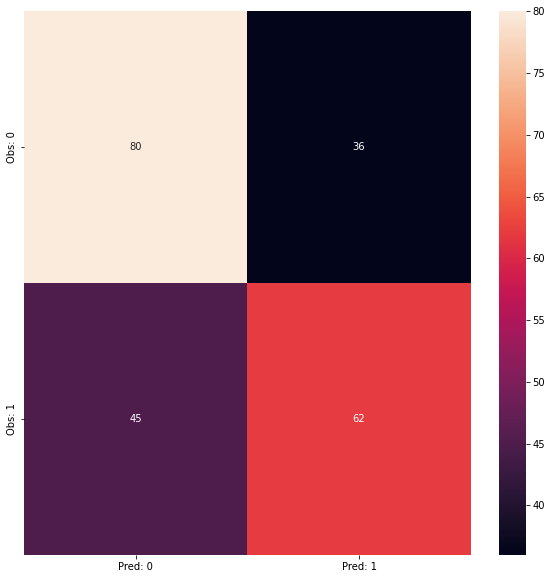

Sensitivity:  0.5794392523364486
Specificity:  0.6896551724137931
Precision:  0.6326530612244898
63.67713004484305


In [62]:
accuracy = check_accuracy(y_test, y_pred, conf_mat='yes')
print(accuracy*100)
# Accuracy is 84.9% now vs 84.6 earlier.
# Not much difference. 

Sensitivity was extremely Low, when the data was imbalanced.

Now it is very close to Specificity and Precision.

Lowering the threshold from 0.5 to a lower value might increase Sensivity

In [63]:
# from sklearn.preprocessing import Binarizer
# for i in range(1,6):
#     y_pred_yes = logreg.predict_proba(x_test)
#     binarize = Binarizer(threshold=i/10)
#     y_pred2 = binarize.fit_transform(y_pred_yes)[:,1]

#     print(i/10)
#     cm_mat = confusion_matrix(y_test, y_pred2)
#     cm_data(cm_mat)

# 0.2 Threshlod looks good.

In [64]:
# Using Grid Search CV to find best parameters.

from sklearn.model_selection import GridSearchCV, cross_val_score

params = {
    'penalty': ['l1', 'l2','elasticnet'],
    'tol': [0.1, 0.01],
    'C': [0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10, 100],
    'multi_class': ['auto', 'ovr','multinomial'],
    'n_jobs': [3,4],
}

grid_log_reg = GridSearchCV(LogisticRegression(), params, cv=5, n_jobs=3)
grid_log_reg.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': [0.1, 0.01], 'max_iter': [10, 100],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'n_jobs': [3, 4],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.1, 0.01]})

In [65]:
best_par = grid_log_reg.best_params_
best_par

{'C': 0.1,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': 3,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 0.1}

In [67]:
best_estimator = grid_log_reg.best_estimator_
best_estimator

LogisticRegression(C=0.1, multi_class='multinomial', n_jobs=3,
                   solver='newton-cg', tol=0.1)

In [68]:
best_log_reg_score = cross_val_score(best_estimator, x_train, y_train, cv = 5)
print(best_log_reg_score.mean()*100)

71.71677860774591


In [84]:
y_pred_grid_proba = grid_log_reg.predict_proba(x_test)
binarize = Binarizer(threshold=0.5)
y_pred_grid = binarize.fit_transform(y_pred_grid_proba)[:,1]
check_accuracy(y_test, y_pred_grid, conf_mat = 'yes')

# Accuracy has risen a little bit, but the data still needs to be balanced.

The Accuracy is very low, So lets try other models.

##### 2: Decision Tree Classifier

##### 3: KNN Classification

##### 4: SVM

##### 5: Neural Networks

##### 6: Complex SVM

##### 7: Complex Neural Networks 

##### 8: Random Forest Classifier

In [88]:
dfp.TenYearCHD = dfp.TenYearCHD.astype('category')
dfp.TenYearCHD.dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [92]:
def RFmodel(df, tar = target_var, submission = 'No', want_acc = 'No', feat_imp = 'No'):

    pred_null, accuracy = 0, 0

    x_train, x_test, y_train, y_test = split_data(df)
    X_train = x_train[:]

    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    if df[tar].dtype in ['float', 'int']:
        model = rfr.fit(x_train, y_train)
        if feat_imp == 'yes':
            features = rfr.feature_importances_
            sorted_indices = np.argsort(features)[::-1]
            plt.title('Feature Importance')
            plt.bar(range(X_train.shape[1]), features[sorted_indices], align='center')
            plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
            plt.tight_layout()
            plt.show()

    elif df[tar].dtype == 'category':
        model = rfc.fit(x_train, y_train)
        if feat_imp == 'yes':
            features = rfc.feature_importances_
            sorted_indices = np.argsort(features)[::-1]
            plt.title('Feature Importance')
            plt.bar(range(X_train.shape[1]), features[sorted_indices], align='center')
            plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
            plt.tight_layout()
            plt.show()
    else:
        print("No Model")

    if (want_acc == 'yes') & (df[tar].dtype in ['int', 'float']):
        accuracy = get_acc(model, x_test, y_test, df[tar].dtype)

    pred_null = model.predict(x_test)

    if want_acc == 'yes':
        accuracy = check_accuracy(y_test, pred_null, conf_mat='yes')


    return pred_null, accuracy

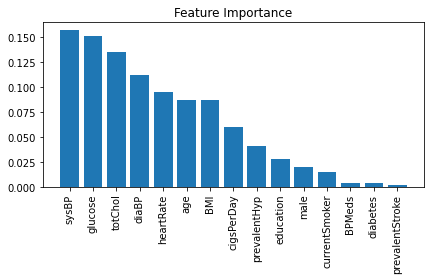

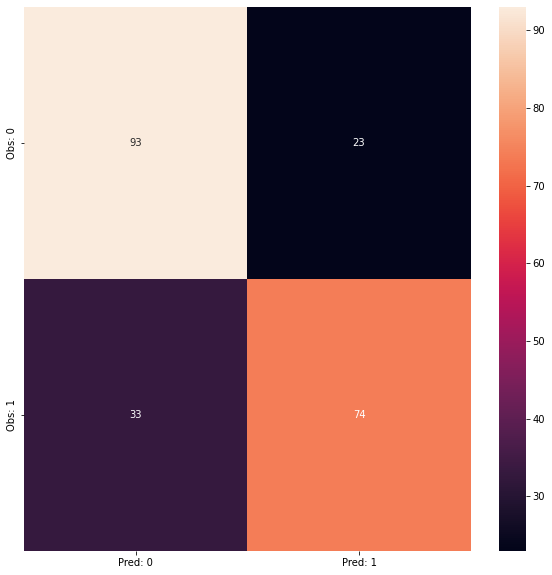

Sensitivity:  0.6915887850467289
Specificity:  0.8017241379310345
Precision:  0.7628865979381443
Accuracy:  0.7488789237668162


In [90]:
pred, accuracy = RFmodel(dfp, want_acc='yes', feat_imp='yes')

##### 9: Boosting